In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import ConstructPortfolio as cp #this will allow us to modularize the code!
#using "ConstructPortfolio.py" that is stored in the same directory! 
#(not using "ConstructPortfolio.ipynb")


/Users/bardiafarajnejad/Desktop/1st Half MFE/AFP/Final Delivery/MFE Group 16 AFP Code


# Buying/selling when a stock becomes marginally more value/growth is informative and has a small spread

In [2]:
#### Please run the line below once in order to get "data_with_rets.pkl" from "afp_data_sample_1995_onward_v2.csv"
#cp.get_data(flag=True)

data = pd.read_pickle('data_with_rets.pkl')
data

,tradedate,osid,symbol,coname,sector_group,max_dt,previoustradedate,tickssinceipo,alpha,stdev_alpha,...,ret1d_lag,alpha1d_lag,ret5d_lag,alpha5d_lag,ret10d_lag,alpha10d_lag,ret15d_lag,alpha15d_lag,ret20d_lag,alpha20d_lag
0,19950103,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19941230.0,8056,0.010006,0.004670,...,0.00000,-0.003112,0.176850,0.166677,0.131841,0.102035,0.144700,0.123317,0.138261,0.106187
1,19950104,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950103.0,8057,-0.003112,0.004656,...,0.01929,0.019820,0.131835,0.124719,0.125412,0.099894,0.173638,0.151438,0.144692,0.115932
2,19950105,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950104.0,8058,0.019820,0.005805,...,0.04732,0.045571,0.119876,0.112258,0.094651,0.075155,0.170357,0.145504,0.135652,0.101416
3,19950106,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950105.0,8059,0.045571,0.009709,...,0.03313,0.032296,0.069278,0.054748,0.063264,0.050293,0.096391,0.070299,0.090370,0.047479
4,19950109,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950106.0,8060,0.032296,0.010892,...,0.06706,0.063220,0.058317,0.037605,0.020420,0.006697,0.046651,0.026290,0.072892,0.026535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912427,20210805,78696,COOK,Traeger Inc,7.0,20210805,20210804.0,6,0.047968,0.026349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912428,20210806,78722,WEBR,Weber Inc Cl A,NaN,20210809,20210805.0,2,0.000000,0.000000,...,0.08190,0.080042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912429,20210809,78722,WEBR,Weber Inc Cl A,7.0,20210809,20210806.0,3,0.080042,0.025773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912430,20210901,78803,FCUV,Focus Universal Inc,NaN,20210902,20210831.0,2,0.000000,0.000000,...,-0.07106,-0.072293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# The code below will allow us to form quantiles (specifically deciles) for ANY variable in our dataframe

### We will form deciles by DAY (not by month...) for any variable we want

In [3]:
K = 10 # Number of deciles to create!
#####################################################################################
#####################################################################################
#NOTE: K=10 is preset for 'summary_stats_bull_OR_bear' ... ONLY K=10 will work for 'summary_stats_bull_OR_bear'
#NOTE: 'create_quantiles' & 'summary_stats_plots' can work with any K
#####################################################################################
#####################################################################################

df = data.copy()

#create signal below:
df['aux_signal'] = (df['priceclose'])/(df['epsq1']+df['epsq2']+df['epsq3']+df['epsq4'])

#RISK ADJUST HERE !!!!
df['aux_signal'] = df['aux_signal'] / df['stdev_alpha'] #do both the risk adjusted and the non risk adjusted !!!
#RISK ADJUST HERE !!!!

#DROP MISSING AUX_SIGNALS below:
df = df.loc[df['aux_signal'].notna(),:].reset_index(drop=True).copy()

#df


In [4]:
def create_quantiles(df):  #CAN HANDLE ANY GENERIC K (global variable K defined above ^) !!!
    brkpts = df.groupby(['tradedate'])['aux_signal'].quantile([1/K]).to_frame().reset_index()\
                        .rename(columns={'aux_signal':'brk1'}).drop(columns=['level_1']) #rename aux_signal and drop col

    for i in range(2,K):
        current_label = f'brk{i}'  #new brk
        brkpts = pd.merge(brkpts,df.groupby(['tradedate'])['aux_signal'].quantile([i / K]).to_frame()\
                              .reset_index().rename(columns={'aux_signal':current_label})\
                              .drop(columns=['level_1']),how='left',on=['tradedate']) ##merge 'brkpts' with a new #for each week, qcut aux_signal==Ranking_Ret into i/10, rename aux_signal and drop col
    #each day has its own breakpoint depending on which level of signal are required to be in that bin

    # Merging breakpoints back to panel data
    df = pd.merge(df, brkpts, how='left', on='tradedate')  #merge on day
    
    # Defining portfolios bins
    df['bin'] = np.nan

    df.loc[df['aux_signal'] <= df['brk1'],'bin'] = 1  #if aux_signal<1st brkpt --> then bin=1
    for i in range(2,K): #do the same for all other breakpoints in the dataframe (k=10 brkpts), so i=2,...,k-1
    #         print(str(i)+', ',end="")
        df.loc[(df['aux_signal'] > df[f'brk{i-1}']) 
                   & (df['aux_signal'] <= df[f'brk{i}']),'bin'] = i #falls in ith bin
    df.loc[df['aux_signal'] > df['brk'+str(K-1)],'bin'] = K #last bin

    for i in range(1,K):
        df = df.drop([f'brk{i}'], axis=1) #no longer need the breakpoints (just need the bin#)

    df.drop('aux_signal',axis=1,inplace=True)
    df = df.reset_index().rename(columns={"bin":"decile"}).copy()
    #DEPENDING ON IN BETWEEN WHICH BREAKPOINT THE aux_signal FALLS, THAT IS THE BIN THAT THAT STOCK BELONGS TO ON THAT DAY

    return df


In [5]:
df = create_quantiles(df) #CAN HANDLE ANY GENERIC K (global variable K defined above ^) !!!
df = df.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()
df

,index,tradedate,osid,symbol,coname,sector_group,max_dt,previoustradedate,tickssinceipo,alpha,...,alpha1d_lag,ret5d_lag,alpha5d_lag,ret10d_lag,alpha10d_lag,ret15d_lag,alpha15d_lag,ret20d_lag,alpha20d_lag,decile
0,0,20020214,10048,ADI,Analog Devices Inc,4.0,20210902,20020213.0,7607,-0.012821,...,0.054992,-0.059557,-0.016638,0.040779,0.006299,0.189922,0.083428,0.133365,0.027615,9.0
1,1,20020215,10048,ADI,Analog Devices Inc,4.0,20210902,20020214.0,7608,0.054992,...,-0.004771,-0.031218,-0.041486,0.063638,-0.030563,0.136239,0.007047,0.108407,-0.014037,9.0
2,2,20020219,10048,ADI,Analog Devices Inc,4.0,20210902,20020215.0,7609,-0.004771,...,-0.029098,-0.022965,-0.068847,0.150627,0.023019,0.139781,-0.022641,0.161984,-0.011900,9.0
3,3,20020220,10048,ADI,Analog Devices Inc,4.0,20210902,20020219.0,7610,-0.029098,...,-0.035052,-0.032915,-0.054770,0.132134,0.003232,0.101759,-0.011017,0.122766,0.011503,9.0
4,4,20020221,10048,ADI,Analog Devices Inc,4.0,20210902,20020220.0,7611,-0.035052,...,-0.000318,0.005667,-0.040691,0.216738,0.055856,0.191068,0.039633,0.222948,0.066163,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137191,1137191,20210827,78691,VSCO,Victoria's Secret & Co,7.0,20210902,20210826.0,20,-0.030882,...,-0.029899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1137192,1137192,20210830,78691,VSCO,Victoria's Secret & Co,7.0,20210902,20210827.0,21,-0.029899,...,-0.007836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1137193,1137193,20210831,78691,VSCO,Victoria's Secret & Co,7.0,20210902,20210830.0,22,-0.007836,...,0.021886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1137194,1137194,20210901,78691,VSCO,Victoria's Secret & Co,7.0,20210902,20210831.0,23,0.021886,...,-0.028671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


## Now, we can define a bullish event as the following: a stock goes from a high decile to a low decile
### Bullish if: decile falls
### Bearish if: decile rises
## And will attempt to trade on those days following when the event occurs!

In [6]:
#now can go back to using 'data' instead of 'df=data.copy()' since we won't care about the nan values anymore:

#first, find how many times the indicators flipped from a high decile to a lower decile
#when decile declines --> put a 1 and buy tomorrow
total_buys = sum(df[['osid','decile']].groupby(['osid'])['decile'].diff(1).isin([-i for i in range(1,K)]))

print('\nTotal number of Buys: ',total_buys, ' not accounting for the problem rows!')

#Next, find how many times the indicators flipped from a low decile to a higher decile
#when decile rises --> put a 1 and sell tomorrow
total_sells = sum(df[['osid','decile']].groupby(['osid'])['decile'].diff(1).isin([i for i in range(1,K)]))

print('\nTotal number of Sells: ',total_sells, ' not accounting for the problem rows!')

total = total_buys + total_sells

print('\nTotal number of Events: ',total, ' not accounting for the problem rows!')


print('\n')
for i in range(1,K):
    #ID THE EVENT HERE, and indicate that we will trade on it tomorrow
    df['buy_tomorrow'] = np.where(df[['osid','decile']].groupby(['osid'])['decile'].diff(1) == -i, 1, 0)
    #when decile declines --> put a 1 and trade tomorrow
    print(sum(df['buy_tomorrow']), 'bullish flips of', i, 'deciles')
print('\n')
for i in range(1,K):
    #ID THE EVENT HERE, and indicate that we will trade on it tomorrow
    df['sell_tomorrow'] = np.where(df[['osid','decile']].groupby(['osid'])['decile'].diff(1) == i, 1, 0)
    #when decile rises --> put a 1 and trade tomorrow
    print(sum(df['sell_tomorrow']), 'bearish flips of', i, 'deciles')



Total number of Buys:  65830  not accounting for the problem rows!

Total number of Sells:  79197  not accounting for the problem rows!

Total number of Events:  145027  not accounting for the problem rows!


54490 bullish flips of 1 deciles
6481 bullish flips of 2 deciles
2390 bullish flips of 3 deciles
1098 bullish flips of 4 deciles
567 bullish flips of 5 deciles
296 bullish flips of 6 deciles
148 bullish flips of 7 deciles
69 bullish flips of 8 deciles
291 bullish flips of 9 deciles


75527 bearish flips of 1 deciles
1891 bearish flips of 2 deciles
767 bearish flips of 3 deciles
370 bearish flips of 4 deciles
169 bearish flips of 5 deciles
71 bearish flips of 6 deciles
29 bearish flips of 7 deciles
39 bearish flips of 8 deciles
334 bearish flips of 9 deciles


# Set buy_tomorrow>0 when decile flips downwards
# Set Sell_tomorrow>0 when decile flips upwards

In [7]:
#define event using indicator for buy and sell:
df = df.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()

df = df.loc[df['decile'].notna(),:].reset_index(drop=True).copy()

df['buy_tomorrow'] = np.where(df[['osid','decile']].groupby(['osid'])['decile'].diff(1).isin([-i for i in range(1,K)]), 1, 0)
df['sell_tomorrow'] = np.where(df[['osid','decile']].groupby(['osid'])['decile'].diff(1).isin([i for i in range(1,K)]), 1, 0)

#data[['tradedate','symbol','sp100f','sp500f','nasdaq100f','buy_tomorrow','sell_tomorrow']]

print('Total number of Buys: ',np.count_nonzero(df['buy_tomorrow']))
print('Total number of Sells: ',np.count_nonzero(df['sell_tomorrow']))

print('Unique buy_tomorrow values: ',np.unique(df['buy_tomorrow'])) #there are only 0 or 1 values in 'buy_tomorrow'
print('Unique sell_tomorrow values: ',np.unique(df['sell_tomorrow'])) #there are only 0 or 1 values in 'sell_tomorrow'


Total number of Buys:  65830
Total number of Sells:  79197
Unique buy_tomorrow values:  [0 1]
Unique sell_tomorrow values:  [0 1]


In [8]:
#VALID LAGS ONLY!
data = cp.trade_on_valid_lags_only(df.copy())


There are  105  problems for buying

There are  78  problems for selling
Total number of Buys:  65725
Total number of Sells:  79119


# Now we can trade!
### Holding period of 1 week, 2 weeks, 3 weeks, and 4 weeks with equal weighted portfolios!

# First, create daily equal weighted portfolio weights and returns (NOT AT THE WEEKLY frequency because that will mess up the implementation of the portfolio!). Problem is:

##### Think (part 1): 1st signal on Monday- want to buy on Tuesday and hold for 1 week in an equal weighted portfolio
##### Think (part 2): 2nd signal on Thursday- want to buy on Friday and hold for 1 week in an equal weighted portfolio
##### Think (part 3): Will have overlapping portfolio between 1st and 2nd signal on Friday and on Monday

## Then, for 1 week, 2 week, 3 week, and 4 week holding periods, we must do the following:
##### extend "buy_tomorrow" and "sell_tomorrow" forward for 4 more trading days

In [9]:
data_smaller,data_smaller5,data_smaller10,data_smaller15,data_smaller20 = cp.pull_signal_forward(data)

data_smaller20 = cp.trade_on_valid_lags_only(data_smaller20)
data_smaller15 = cp.trade_on_valid_lags_only(data_smaller15)
data_smaller10 = cp.trade_on_valid_lags_only(data_smaller10)
data_smaller5 = cp.trade_on_valid_lags_only(data_smaller5)
data_smaller = cp.trade_on_valid_lags_only(data_smaller)




There are  480  problems for buying

There are  548  problems for selling
Total number of Buys:  705330
Total number of Sells:  777255

There are  411  problems for buying

There are  483  problems for selling
Total number of Buys:  606349
Total number of Sells:  690384

There are  297  problems for buying

There are  391  problems for selling
Total number of Buys:  471169
Total number of Sells:  559415

There are  170  problems for buying

There are  219  problems for selling
Total number of Buys:  282202
Total number of Sells:  348355

There are  2  problems for buying

There are  0  problems for selling
Total number of Buys:  65689
Total number of Sells:  79084


# First, do 1 day holding period: data_smaller
# Next, do 5 day holding period: data_smaller5
# Next, do 10 day holding period: data_smaller10
# Next, do 15 day holding period: data_smaller15
# Next, do 20 day holding period: data_smaller20



There are  3  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  2  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.333
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.19e-06
Time:                        18:21:20   Log-Likelihood:                 12784.
No. Observations:                4837   AIC:                        -2.555e+04
Df Residuals:                    4830   BIC: 

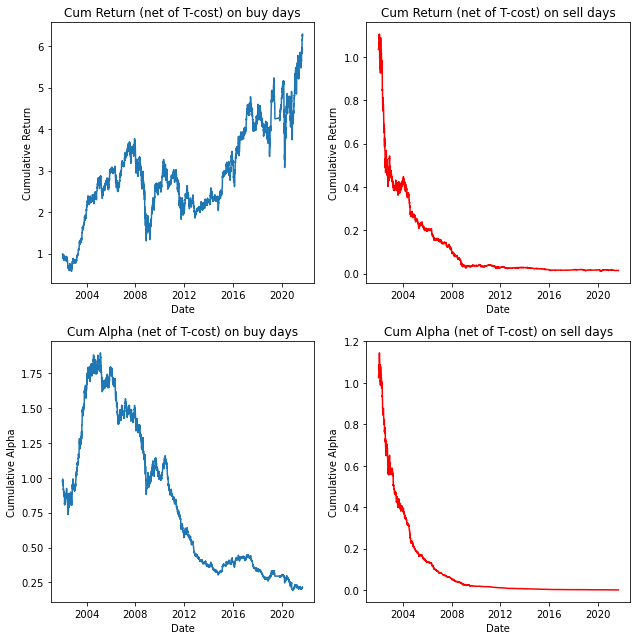

In [10]:
# 1 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller)


There are  2  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     7.283
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           9.20e-08
Time:                        18:21:54   Log-Likelihood:                 13283.
No. Observations:                4848   AIC:                        -2.655e+04
Df Residuals:                    4841   BIC: 

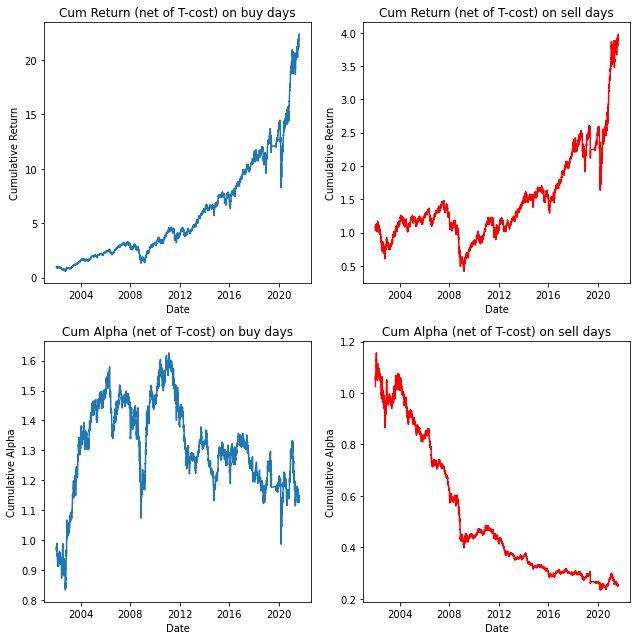

In [11]:
# 5 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller5)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     7.237
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.04e-07
Time:                        18:22:46   Log-Likelihood:                 13344.
No. Observations:                4853   AIC:                        -2.667e+04
Df Residuals:                    4846   BIC: 

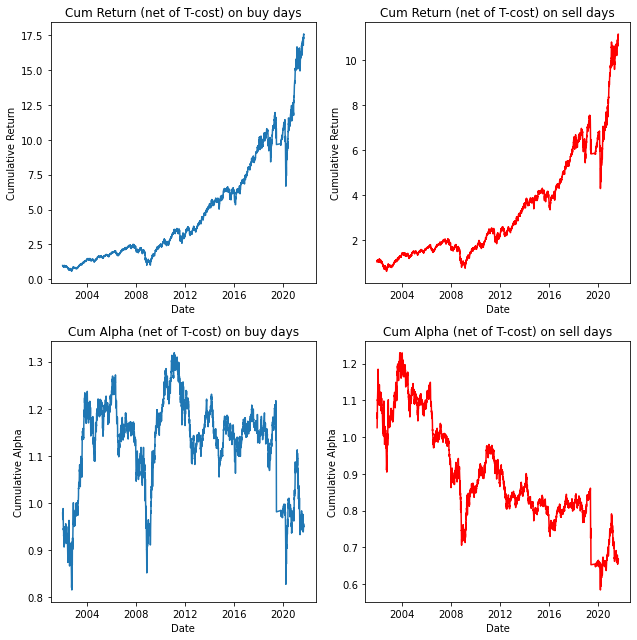

In [12]:
# 10 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller10)


There are  3  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     7.000
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.98e-07
Time:                        18:23:39   Log-Likelihood:                 13356.
No. Observations:                4853   AIC:                        -2.670e+04
Df Residuals:                    4846   BIC: 

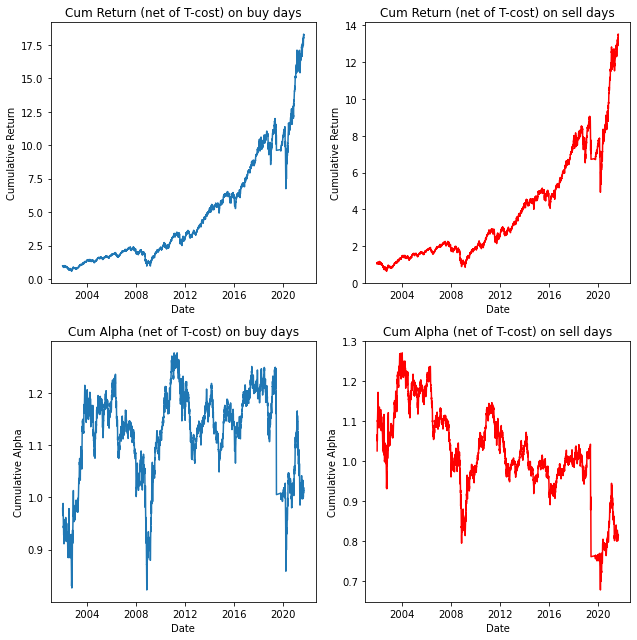

In [13]:
# 15 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller15)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  2  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     7.035
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.80e-07
Time:                        18:24:45   Log-Likelihood:                 13361.
No. Observations:                4853   AIC:                        -2.671e+04
Df Residuals:                    4846   BIC: 

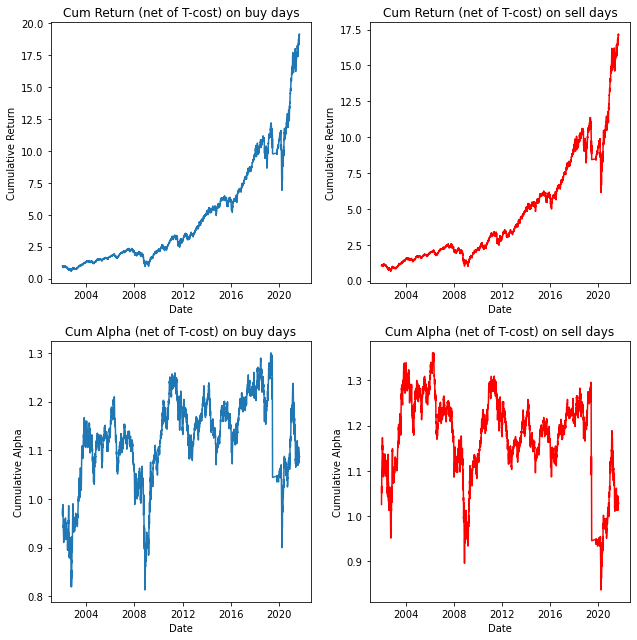

In [14]:
# 20 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller20)